In [1]:
from tadiza import *
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import random

In [2]:
class SingleInference(LightningModule):
    def __init__(self):
        super().__init__()
        net = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = net.roi_heads.box_predictor.cls_score.in_features
        net.roi_heads.box_predictor = (
            torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)
        )
        self.model = net

    def forward(self, x):
        return self.model(x)

In [3]:
module = SingleInference()
module.model.load_state_dict(torch.load("maskdetection-3.pth"))

<All keys matched successfully>

In [4]:
coco = COCO(os.path.join("maskdetection-3", "test", "_annotations.coco.json"))
img_id = list(sorted(coco.imgs.keys()))
random_img_id = random.choice(img_id)

img_path = coco.loadImgs(random_img_id)[0]["file_name"]
print(f'File yang dijadikan untuk testing: {img_path}')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
File yang dijadikan untuk testing: 651-subject-2_jpg.rf.38b1b83f291375960b01ee2108a71823.jpg


In [5]:
img = cv2.imread(os.path.join("maskdetection-3", "test", img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([ToTensorV2()])
img = transform(image=img)["image"]
img = img.div(255)

bbox = coco.loadAnns(coco.getAnnIds(random_img_id))[0]["bbox"]
bbox = [[bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]]
print(f"Bounding Box: {bbox}")

Bounding Box: [[24, 27, 52.28, 50.85]]


In [6]:
module.eval()
preds = module([img])
preds_bbox = preds[0]["boxes"][0].expand(1, 4)
print(f"Predicted Bounding Box: {preds_bbox.detach().numpy()}")
print(f'Predicted Score: {preds[0]["scores"][0].detach().numpy()}')
iou = torchvision.ops.box_iou(preds_bbox, torch.tensor(bbox))
preds_bbox = preds_bbox.detach().numpy()

Predicted Bounding Box: [[24.591839 28.791132 50.02763  47.623566]]
Predicted Score: 0.9582016468048096


# Plot Gambar

<function matplotlib.pyplot.show(close=None, block=None)>

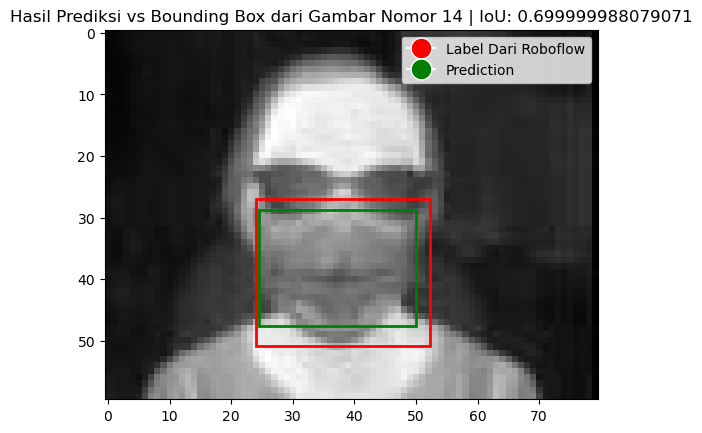

In [7]:
plt.figure()
plt.title(f"Hasil Prediksi vs Bounding Box dari Gambar Nomor {random_img_id} | IoU: {iou.squeeze().detach().numpy().round(1)}")
plt.imshow(img.permute(1, 2, 0))

# ingat diza, rect ini pakai format x,y,w,h bukan format dari model
rect = patches.Rectangle(
    (bbox[0][0], bbox[0][1]),
    bbox[0][2] - bbox[0][0],
    bbox[0][3] - bbox[0][1],
    linewidth=2,
    edgecolor="r",
    facecolor="none",
)
plt.gca().add_patch(rect)


rect2 = patches.Rectangle(
    (preds_bbox[0][0], preds_bbox[0][1]),
    preds_bbox[0][2] - preds_bbox[0][0],
    preds_bbox[0][3] - preds_bbox[0][1],
    linewidth=2,
    edgecolor="g",
    facecolor="none",
)
plt.gca().add_patch(rect2)

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Label Dari Roboflow",
        markerfacecolor="r",
        markersize=15,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Prediction",
        markerfacecolor="g",
        markersize=15,
    ),
]
plt.legend(handles=legend_elements, loc="upper right")

plt.show